# usALEX - Corrections - Direct excitation physical parameter

> *This notebook estimates direct excitation coefficient $d_{exT}$ from μs-ALEX data.*

## Aim

### What is already computed?

We previously fitted the **leakage** and **gamma** coefficient from the RAW PR values for the 5 measurements. We also fitted the
direct excitation coefficient expressed (`dir_ex_aa`) as a function of the A-signal during A-excitation (`naa`). In symbols, `dire_ex_aa` is defined as:

$$ d_{exAA} = \frac{n_{a}}{n_{aa}}$$

for a A-only population.

### What we want to compute?

An alternative defition of the direct excitation coefficient (`dir_ex_t`, $d_{exT}$) relies only on physical properties but, differently from `dir_ex_aa`, it cannot be expressed as a function of μs-ALEX quatitites.

The definition of $d_{exT}$ is:

$$ d_{exT} = \frac{\sigma_{A532}}{\sigma_{A532}}$$

where $\sigma_{A532}$ and $\sigma_{D532}$ are the absorption cross-sections of the Acceptor and Donor dye at 532nm.

Once dyes and excitation wavelength are fixed this coefficien is also fixed. Moreover, since $d_{exT}$ is independent from μs-ALEX quantities, it can also used to correct the non-ALEX multi-spot measurements.

### How we compute it?

Here, we correct the RAW PR values using the formula for leakage + direct excitation (`dir_ex_t`) + gamma correction. Since we already estimated leakage and gamma,  we fit `dir_ex_t` in order to match the corrected FRET efficiencies obtained from corrected FRET histograms. The fitted direct excitation (`dir_ex_t`) will be finally used to correct the multi-spot measurements.

## Library imports

In [1]:
from __future__ import division
import os
import numpy as np
import pandas as pd
import lmfit

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Load data RAW PR data

In [2]:
#bsearch_ph_sel = 'AND-gate'
bsearch_ph_sel = 'Dex'

data_file = 'results/usALEX-5samples-PR-raw-%s.txt' % bsearch_ph_sel

These are the **RAW proximity ratios** for the 5 samples (only background correction, no leakage nor direct excitation):

In [3]:
data_raw = pd.read_csv(data_file, sep="\s+").set_index('sample')
data_raw[['E_gauss_w', 'E_kde_w']]

,E_gauss_w,E_kde_w
sample,,
7d,0.927281,0.9336
12d,0.748524,0.7510
17d,0.480718,0.4908
22d,0.280169,0.2752
27d,0.194758,0.1944


## Load μs-ALEX corrections

In [4]:
leakage_coeff_fname = 'results/usALEX - leakage coefficient DexDem.txt'
leakage = np.loadtxt(leakage_coeff_fname)

print 'Leakage coefficient:', leakage

Leakage coefficient: 0.0999990383646


In [5]:
dir_ex_t_datasheet_fname = 'results/Dyes - ATT0647N-ATTO550 abs X-section ratio at 532nm.txt'
dir_ex_t_datasheet = np.loadtxt(dir_ex_t_datasheet_fname)

print 'Direct excitation (dir_ex_t) from datasheet:', dir_ex_t_datasheet

Direct excitation (dir_ex_t) from datasheet: 0.106516290727


In [6]:
gamma_coeff_fname = 'results/usALEX - gamma factor - all-ph.txt'
gamma = np.loadtxt(gamma_coeff_fname)

print 'Gamma factor:', gamma

Gamma factor: 1.01675481635


## Load E data from corrected FRET bursts

And these are the **FRET efficiencies** fitted from corrected histograms for the same 5 samples: 

In [7]:
data_file = 'results/usALEX-5samples-E-corrected-all-ph.txt'
data_corr = pd.read_csv(data_file, sep="\s+").set_index('sample')
data_corr[['E_gauss_w', 'E_kde_w']]

,E_gauss_w,E_kde_w
sample,,
7d,0.923612,0.9290
12d,0.727858,0.7396
17d,0.422469,0.4266
22d,0.180234,0.1762
27d,0.082579,0.0820


### Proximity Ratio correction formula

The expression to convert RAW PR values to corrected FRET efficiencies:

$$ E = \frac{E_{R} \left(L_{k} + d_{exT} \gamma + 1\right) - L_{k} - d_{exT} \gamma}{E_{R} \left(L_{k} - \gamma + 1\right) - L_{k} + \gamma}$$

*See [Derivation of FRET and S correction formulas](Derivation of FRET and S correction formulas.ipynb) for the derivation*.

We load [FRETBursts software](https://github.com/tritemio/FRETBursts/) that provides this function (as `fretmath.correct_E_gamma_leak_dir`):

In [8]:
%run load_fretbursts.py --nogui

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
-------------------------------------------------------------


 You are running FRETBursts (version 0.4rc10-7-gb2e1b5d).

 If you use this software in a publication, please cite it as:

   FRETBursts - An opensource single-molecule FRET bursts analysis toolkit.
   A. Ingargiola 2014. https://github.com/tritemio/FRETBursts

-------------------------------------------------------------

FRETBursts version: 0.4rc10-7-gb2e1b5d
-------------------------------------------------------------
 You are running FRETBursts (version 0.4rc10-7-gb2e1b5d).

 If you use this software in a publication, please cite it as:

   FRETBursts - An opensource single-molecule FRET bursts analysis toolkit.
   A. Ingargiola 2014. https://github.com/tritemio/FRETBursts

-------------------------------------------------------------


## Comparison of datasheet-based *vs* μs-ALEX-based direct excitation

Using [datasheet values](dyes/Absorption ATTO550-ATTO647N.ipynb) for $d_{exT}$ we the following FRET efficiencies:

In [9]:
E_datasheet = fretmath.correct_E_gamma_leak_dir(data_raw.E_kde_w, 
                                                leakage=leakage, 
                                                dir_ex_t=dir_ex_t_datasheet,
                                                gamma=gamma)*100
E_datasheet

sample
7d     92.488108
12d    71.393154
17d    40.176358
22d    13.220054
27d     2.850513
Name: E_kde_w, dtype: float64

In [10]:
out = data_corr[['E_kde_w']].copy()*100
out.columns = ['E_alex']
out['E_datasheet'] = E_datasheet
out

,E_alex,E_datasheet
sample,,
7d,92.90,92.488108
12d,73.96,71.393154
17d,42.66,40.176358
22d,17.62,13.220054
27d,8.20,2.850513


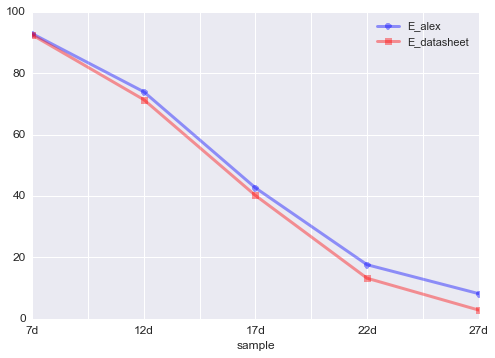

In [11]:
out.plot(alpha=0.4, lw=3, style=dict(E_alex='-ob', E_datasheet='-sr'));

> **NOTE:** The corrected FRET efficiencies using the datasheet and 
> μs-ALEX-based direct excitation do not match well.

## Fitting of physical direct excitation coefficient $d_{exT}$

In [12]:
import lmfit

In [13]:
def residuals_absolute(params, E_raw, E_ref):
    dir_ex_t = params['dir_ex_t'].value
    return E_ref - fretmath.correct_E_gamma_leak_dir(E_raw, 
                                                     leakage=leakage, 
                                                     gamma=gamma, 
                                                     dir_ex_t=dir_ex_t)

In [14]:
def residuals_relative(params, E_raw, E_ref):
    dir_ex_t = params['dir_ex_t'].value
    return (E_ref - fretmath.correct_E_gamma_leak_dir(E_raw, 
                                                      leakage=leakage, 
                                                      gamma=gamma, 
                                                      dir_ex_t=dir_ex_t))/E_ref

In [15]:
params = lmfit.Parameters()
params.add('dir_ex_t', value=0.05) 

In [16]:
m = lmfit.minimize(residuals_absolute, params, args=(data_raw.E_kde_w, data_corr.E_kde_w))
lmfit.report_fit(m.params, show_correl=False)

[[Variables]]
    dir_ex_t:   0.04832329 +/- 0.004859 (10.06%) (init= 0.05)


In [17]:
m = lmfit.minimize(residuals_relative, params, args=(data_raw.E_kde_w, data_corr.E_kde_w))
lmfit.report_fit(m.params, show_correl=False)

[[Variables]]
    dir_ex_t:   0.04643110 +/- 0.001289 (2.78%) (init= 0.04832329)


> **NOTE:** The fitted `dir_ex_t` is 4.5% as opposed to 10.6% as expected from the [absorption spectra of ATTO550 and ATTO647](dyes/Absorption ATTO550-ATTO647N.ipynb) at 532nm.

In [18]:
m.params['dir_ex_t'].value

0.046431103621299652

In [19]:
with open('results/usALEX - direct excitation coefficient dir_ex_t.txt', 'w') as f:
    f.write(str(m.params['dir_ex_t'].value))

## Use `dir_ex_t` ($d_{exT}$) to obtain corrected $E$

In [20]:
data_raw

,n_bursts_all,n_bursts_do,n_bursts_fret,E_kde_w,E_gauss_w,E_gauss_w_sig,E_gauss_w_err,S_kde,S_gauss,S_gauss_sig,S_gauss_err,E_pr_do_kde,nt_mean
sample,,,,,,,,,,,,,
7d,1653,955,641,0.9336,0.927281,0.054494,0.002152,0.5752,0.577278,0.100331,0.003963,0.0982,23.005923
12d,1690,486,1155,0.7510,0.748524,0.084144,0.002476,0.5996,0.589008,0.104657,0.003079,0.1026,23.376161
17d,3451,764,2584,0.4908,0.480718,0.101802,0.002003,0.5754,0.583630,0.108354,0.002132,0.1056,23.046040
22d,2801,501,2184,0.2752,0.280169,0.067912,0.001453,0.5768,0.583304,0.110295,0.002360,0.0938,26.572532
27d,1145,314,793,0.1944,0.194758,0.057257,0.002033,0.5800,0.605761,0.108450,0.003851,0.0882,19.855257


In [21]:
E_corr_pr = fretmath.correct_E_gamma_leak_dir(data_raw.E_kde_w, 
                                              leakage=leakage, 
                                              dir_ex_t=m.values['dir_ex_t'],
                                              gamma=gamma)*100
E_corr_pr

sample
7d     92.896013
12d    72.946541
17d    43.424855
22d    17.932311
27d     8.125849
Name: E_kde_w, dtype: float64

In [22]:
out['E_corr_pr'] = E_corr_pr
out

,E_alex,E_datasheet,E_corr_pr
sample,,,
7d,92.90,92.488108,92.896013
12d,73.96,71.393154,72.946541
17d,42.66,40.176358,43.424855
22d,17.62,13.220054,17.932311
27d,8.20,2.850513,8.125849


1.0134592255185311

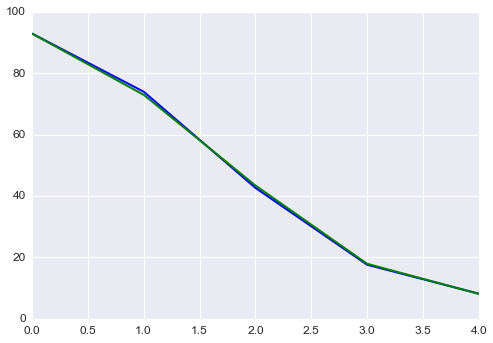

In [23]:
plot(out['E_alex'])
plot(out['E_corr_pr'])
(out['E_alex'] - out['E_corr_pr']).abs().max()

In [24]:
(out['E_alex'] - out['E_corr_pr'])

sample
7d     0.003987
12d    1.013459
17d   -0.764855
22d   -0.312311
27d    0.074151
dtype: float64

> **NOTE:** Fitting $d_{exT}$ to match $E$ from corrected hsitograms with $E$ from PR correction formula produces a max difference of 1% for the 12d sample. The match is well below the fitting accuracy (> 2%).